# Plot Dice Means from CV Sweep

## Setup

In [45]:
# imports
import csv
from collections import defaultdict
from dataclasses import dataclass
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
from pathlib import Path
import re


In [46]:
# config
ROOT = '/ministorage/adina/selma_segmentation_preds/preds'
SUBTYPES = ['ALL'] # ['amyloid_plaque_patches', 'c_fos_positive_patches', 'cell_nucleus_patches', 'vessels_patches']
EXCLUDE_SUBTYPES = ['cv_folds']
OUTPUT_DIR = None
ASCENDING = False # sort x-axis lowest to highest if True
SAVE_SUMMARY_CSV = False
PLOT_COMBINED = True # plot combined curve for all subtypes in one plot


## Classes and functions

In [47]:
@dataclass
class CVPoint:
    subtype: str # subtype name
    train_count: int # number of training samples for finetuning
    mean_dice: float # mean dice score
    fold_id: int # fold id
    tag: str
    csv_path: Path # path to csv file with metrics


In [48]:
# function to find subtypes 
def find_subtypes(root, requested, exclude=None):
    
    # if all requested, find all subtypes
    if any(s.upper() == 'ALL' for s in requested):
        subtypes = sorted([d.name for d in root.iterdir() if d.is_dir()])

        # exclude if needed
        if exclude:
            subtypes = [s for s in subtypes if s not in set(exclude)]

        return subtypes

    # otherwise, return requested subtypes
    return requested


In [49]:
# function to parse counts from filename
def parse_counts_from_filename(tag):

    # regex for parsing tag names
    RE_CVFOLD = re.compile(r'cvfold(\d+)') # ex: cvfold0
    RE_FOLD = re.compile(r'_fold(\d+)') # ex: _fold0
    RE_NTR = re.compile(r'_ntr(\d+)') # ex: _ntr10 (preferred for train size)
    RE_TRLIM = re.compile(r'_trlim(\d+|ALL)') # ex: _trlim10 or _trlimALL

    # search fold id
    match = RE_CVFOLD.search(tag)
    if match:
        fold_id = int(match.group(1))
    else:
        match = RE_FOLD.search(tag)
        fold_id = int(match.group(1)) if match else -1

    # search train count
    k = None
    match = RE_NTR.search(tag)
    if match:
        k = int(match.group(1))
    else:
        match = RE_TRLIM.search(tag)
        if match:
            val = match.group(1)
            if val != 'ALL':
                try:
                    k = int(val)
                except Exception:
                    k = None
    
    return fold_id, k


In [50]:
# function to read mean dice from CSV
def read_mean_dice_from_csv(csv_path):

    try:
        # open file
        with open(csv_path, 'r', newline='') as f:

            # read mean dice from file
            reader = csv.DictReader(f)
            for row in reader:
                if row.get('filename', '').strip().lower() == 'mean':
                    try:
                        return float(row['dice_050'])
                    except Exception:
                        return None

    except FileNotFoundError:
        return None
    
    return None


In [51]:
# scan subtypes preds for metrics csv and build list
def collect_subtype_points(subtype, root):

    # list to hold points
    points = []

    # subdir
    subdir = root / subtype
    if not subdir.exists():
        print(f'[WARN] Missing subtype directory: {subdir}')
        return points
    
    # tags
    tag_dirs = sorted([d for d in subdir.iterdir() if d.is_dir()])
    if not tag_dirs:
        print(f'[WARN] No tag directories found in {subdir}')
        return points
    
    found_csv = 0
    
    # iterate over tag dirs
    for tag_dir in tag_dirs:
        tag = tag_dir.name
        preds_dir = tag_dir / 'preds'
        search_dirs = [preds_dir] if preds_dir.exists() else [tag_dir]
        
        for base in search_dirs:
            for csv_path in base.glob('metrics_test_*.csv'):
                found_csv += 1
                fold_id, train_k = parse_counts_from_filename(tag)
                if train_k is None:
                    print(f'[WARN] Could not parse train count from tag "{tag}" in {csv_path}, skipping.')
                    continue

                # read mean dice
                mean_dice = read_mean_dice_from_csv(csv_path)
                if mean_dice is None or np.isnan(mean_dice):
                    print(f'[WARN] Mean dice not found or NaN in {csv_path}, skipping.')
                    continue

                # create CVPoint and add to list
                points.append(CVPoint(
                    subtype=subtype, 
                    train_count=train_k, 
                    mean_dice=float(mean_dice), 
                    fold_id=fold_id, 
                    tag=tag, 
                    csv_path=csv_path))
        
    print(f'[INFO] {subtype}: Scanned {len(tag_dirs)} tags, found {found_csv} CSV files, collected {len(points)} points.')
            
    # return list of points
    return points


## Plotting

In [100]:
# function to plot curve
def plot_subtype_curve(subtype, points, outdir=None, ascending=False):

    # return if no points
    if not points:
        print(f'[WARN] No points to plot for {subtype}. Skipping.')
        return None
    
    # group points by fold id
    by_fold = defaultdict(list)
    for p in points:
        by_fold[p.fold_id].append(p)

    # define markers
    # marker_cycle = ['o', 's', '^', 'D', 'v', 'P', 'X', '*', '<', '>', 'H', 'h']
    fold_ids = sorted(by_fold.keys())

    # create plot
    plt.figure(figsize=(8, 6))
    for idx, fid in enumerate(fold_ids):
        pts = sorted(by_fold[fid], key=lambda r: r.train_count, reverse=not ascending)
        xs = [r.train_count for r in pts]
        ys = [r.mean_dice for r in pts]
        marker = 'o'
        # plt.plot(xs, ys, linestyle=None, marker=marker, label=f'Fold {fid}')
        plt.scatter(xs, ys, marker=marker, label=None, color='deepskyblue', alpha=0.6)

    # add line of best fit
    xs_all = [r.train_count for r in points]
    ys_all = [r.mean_dice for r in points]
    if len(xs_all) >= 2:
        x_min, x_max = min(xs_all), max(xs_all)
        xfit = np.linspace(x_min, x_max, 100)
        coeffs = np.polyfit(xs_all, ys_all, deg=1) # linear fit
        yfit = np.polyval(coeffs, xfit)
        plt.plot(xfit, yfit, linestyle='-', color='dimgray', alpha=0.7, label='Best fit (all folds)')

        # plt.scatter(xs, ys, marker=marker, label=f'Fold {fid}')


    # x ticks
    ax = plt.gca()
    if xs_all:
        ax.set_xticks(range(min(xs_all), max(xs_all)+1, 1))
        ax.xaxis.set_major_locator(mticker.MultipleLocator(1))
    if not ascending:
        ax.invert_xaxis()


    # label
    plt.xlabel('Train size (num finetune patches before finetune train/val split)')
    plt.ylabel('Mean dice @0.5 (test set)')
    plt.title(f'{subtype}: CV performance vs. train_count')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(loc='best')
    plt.tight_layout()

    # save plot
    if outdir is not None:
        outdir.mkdir(parents=True, exist_ok=True)
        outpath = outdir / f'{subtype}_cv_dice_vs_train.png'
        plt.savefig(outpath)
        return outpath

    # show plot
    plt.show()




In [101]:
# function to plot all subtypes
def plot_all_subtypes(subtype_to_points, outdir=None, ascending=False):

    # filter to subtypes with at least 1 point
    filtered = {k: v for k, v in subtype_to_points.items() if v}
    if not filtered:
        print('[WARN] No subtypes with points to plot. Skipping combined plot.')
        return None
    
    # create plot
    plt.figure(figsize=(10, 6))

    # sort within each subtype by train_count
    for subtype, points in sorted(filtered.items()):
        points_sorted = sorted(points, key=lambda r: r.train_count, reverse=not ascending)
        xs = [r.train_count for r in points_sorted]
        ys = [r.mean_dice for r in points_sorted]
        plt.scatter(xs, ys, marker='o', label=subtype, alpha=0.7)

    # x ticks
    ax = plt.gca()
    all_xs = [p.train_count for points in filtered.values() for p in points]
    if all_xs:
        ax.set_xticks(range(min(all_xs), max(all_xs)+1, 1))
        ax.xaxis.set_major_locator(mticker.MultipleLocator(1))
    if not ascending:
        ax.invert_xaxis()

    # label
    plt.xlabel('Train size (num finetune patches before finetune train/val split)')
    plt.ylabel('Mean dice @0.5 (test set)')
    plt.title('All subtypes: Dice vs. train_size')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(loc='best')
    plt.tight_layout()

    # show plot    
    plt.show()

    # save plot
    if outdir is not None:
        outdir.mkdir(parents=True, exist_ok=True)
        outpath = outdir / 'all_subtypes_dice_vs_train_size.png'
        plt.savefig(outpath)
        return outpath


[INFO] Found subtypes: ['amyloid_plaque', 'c_fos_positive', 'cell_nucleus', 'vessels']
[INFO] amyloid_plaque: Scanned 170 tags, found 170 CSV files, collected 170 points.


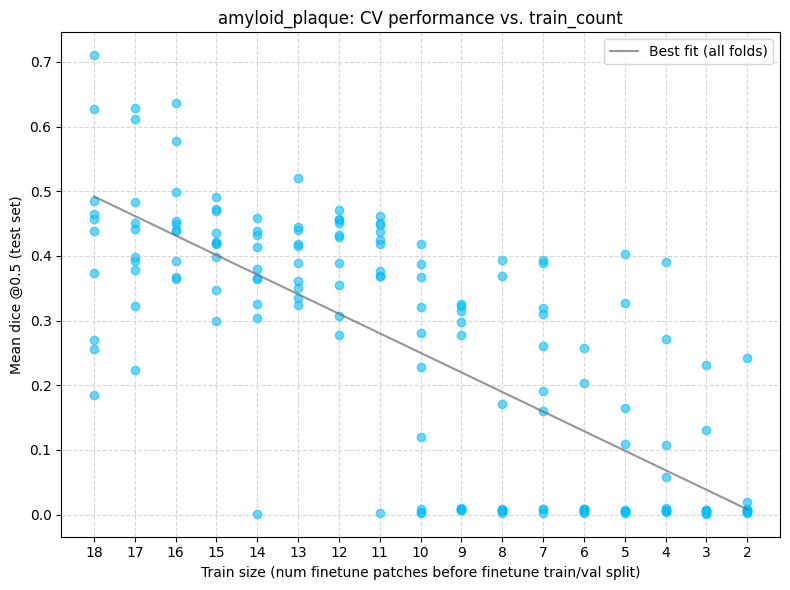

[INFO] c_fos_positive: Scanned 20 tags, found 20 CSV files, collected 20 points.


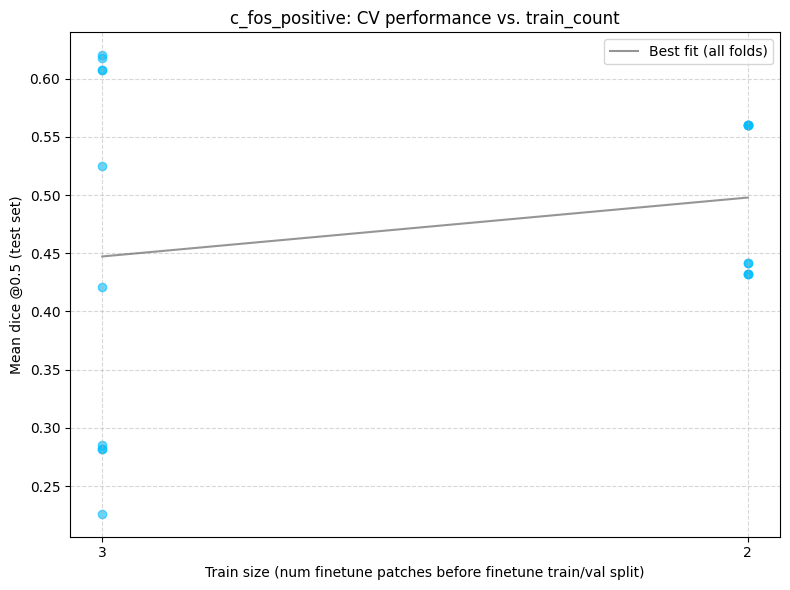

[INFO] cell_nucleus: Scanned 230 tags, found 230 CSV files, collected 230 points.


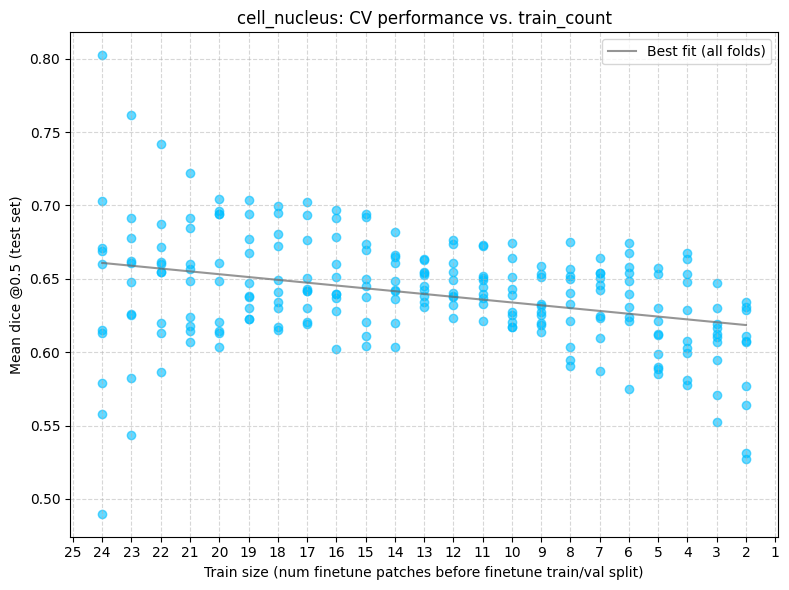

[INFO] vessels: Scanned 188 tags, found 188 CSV files, collected 188 points.


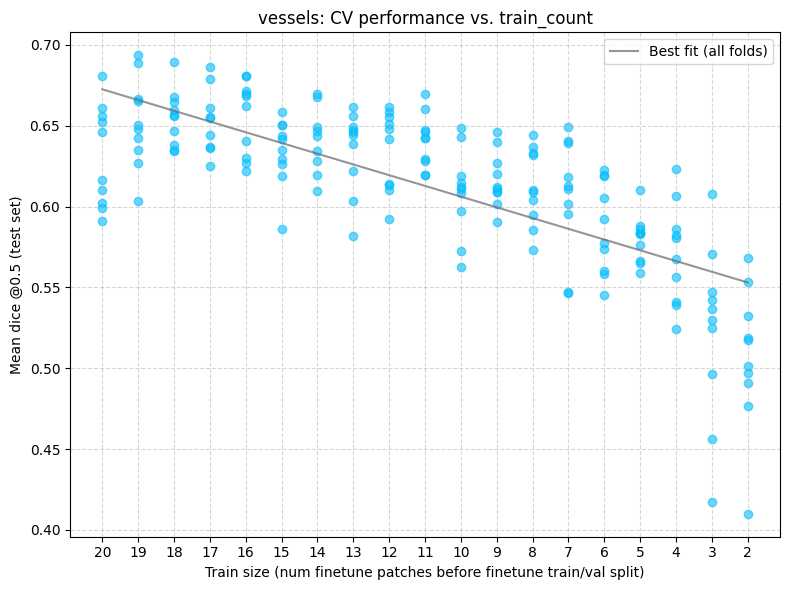

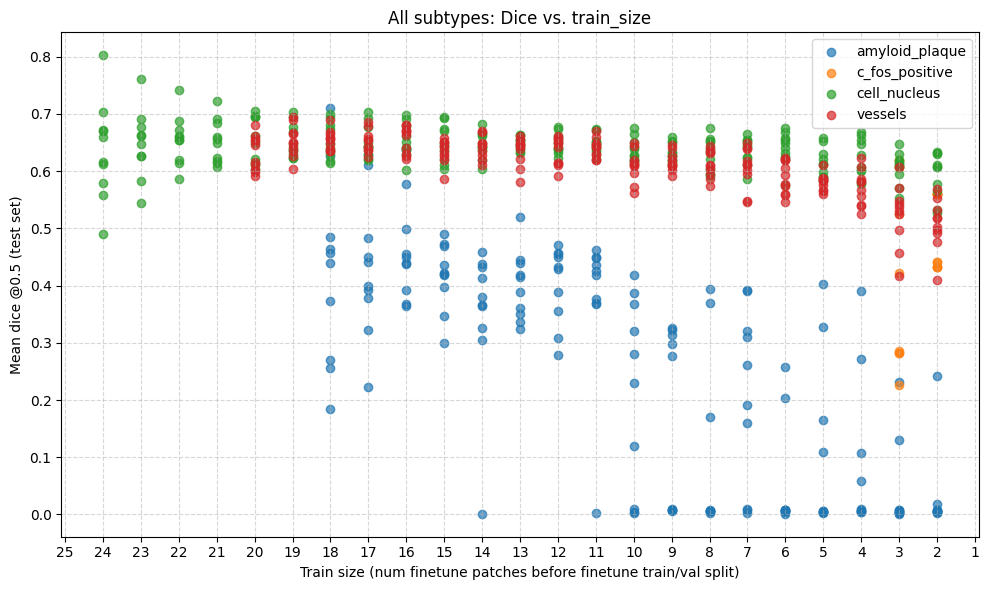

In [102]:
# main

# resolve paths
root = Path(ROOT)
outdir = Path(OUTPUT_DIR) if OUTPUT_DIR else None
# outdir.mkdir(parents=True, exist_ok=True)

# find subtypes
subtypes = find_subtypes(root, SUBTYPES, EXCLUDE_SUBTYPES)
print(f'[INFO] Found subtypes: {subtypes}')

# optionally gather summary csv across all subtypes
summary_rows = []

# keep mapping for combined plot
subtype_to_points = {}

# process each subtype
for subtype in subtypes:

    # collect points (train_count, mean_dice, eval_count)
    points = collect_subtype_points(subtype, root)
    if not points:
        print(f'[WARN] No metrics with MEAN found for {subtype}.')
        continue

    # save for combined plot if needed
    subtype_to_points[subtype] = points

    # accumulate rows for the combined summary csv
    for r in points:
        summary_rows.append({
            'subtype': subtype,
            'train_count': str(r.train_count),
            'fold_id': r.fold_id,
            'mean_dice_050': f'{r.mean_dice:.6f}',
            'metrics_csv': str(r.csv_path),
            'tag': r.tag
        })

    # plot curve for this subtype
    plot_subtype_curve(subtype, points, outdir=outdir, ascending=ASCENDING)


# plot combined curve if requested
if PLOT_COMBINED and subtype_to_points:
    plot_all_subtypes(subtype_to_points, outdir=outdir, ascending=ASCENDING)

# save combined summary csv if requested
if SAVE_SUMMARY_CSV and summary_rows and outdir is not None:
    outdir.mkdir(parents=True, exist_ok=True)
    summary_csv = outdir / 'dice_vs_traincount_summary.csv'
    with open(summary_csv, 'w', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=['subtype', 'train_count', 'fold_id', 'mean_dice_050', 'metrics_csv', 'tag'])
        writer.writeheader()
        writer.writerows(summary_rows)
    print(f'[INFO] Saved summary CSV to {summary_csv}')
